Before running the following code cells, You have to change the Accelerator status from None to <code>TPU VM v3-8</code> because, in this notebook, we're going to use TPU as the computing processing units. You can do this in the edit mode by clicking on the three dots located in the upper right corner.

In [1]:
!pip install seaborn
!pip install nltk
!pip install tensorflow
!pip install tensorflow_addons

!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.0/777.0 kB 33.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 263.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 2.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Dropout, Input, Dense
from transformers import DistilBertTokenizer, TFAutoModel, AdamWeightDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow_addons.metrics import F1Score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import regex as re
import pickle
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('wordnet')

D0202 16:49:26.203135713      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0202 16:49:26.203162233      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0202 16:49:26.203165869      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0202 16:49:26.203168495      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0202 16:49:26.203170936      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0202 16:49:26.203173502      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0202 16:49:26.203175865      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0202 16:49:26.

True

# Attivare TPU
Richiede di attivare accelerazione TPU a Kaggle, possibile che metta la richiesta in coda
Inoltre, estrae la distribution strategy, che poi sarà passata al momento dell'esecuzione per ottimizzare


In [ ]:
try:
    tpu_cluster = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu_cluster.master())
except ValueError:
    tpu_cluster = None # It assigns None to the tpu_cluster variable, indicating that no TPU is available

if tpu_cluster: # is not None
    tf.config.experimental_connect_to_cluster(tpu_cluster)
    tf.tpu.experimental.initialize_tpu_system(tpu_cluster)
    dist_strategy = tf.distribute.TPUStrategy(tpu_cluster) # use a distribution strategy related to the presence of TPU 
else: # is None
    dist_strategy = tf.distribute.get_strategy() # use a distribution strategy related to the absence of TPU 

print('The number of Replica involved in strategy :', dist_strategy.num_replicas_in_sync)


## **Data Loading & Pre Processing**

In [5]:
df = pd.read_json("/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json", lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [6]:
#df = df[['headline', 'short_description', 'category']] # TODO feature selection ?
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [7]:
from collections import Counter
Counter(df.category)

Counter({'U.S. NEWS': 1377,
         'COMEDY': 5400,
         'PARENTING': 8791,
         'WORLD NEWS': 3299,
         'CULTURE & ARTS': 1074,
         'TECH': 2104,
         'SPORTS': 5077,
         'ENTERTAINMENT': 17362,
         'POLITICS': 35602,
         'WEIRD NEWS': 2777,
         'ENVIRONMENT': 1444,
         'EDUCATION': 1014,
         'CRIME': 3562,
         'SCIENCE': 2206,
         'WELLNESS': 17945,
         'BUSINESS': 5992,
         'STYLE & BEAUTY': 9814,
         'FOOD & DRINK': 6340,
         'MEDIA': 2944,
         'QUEER VOICES': 6347,
         'HOME & LIVING': 4320,
         'WOMEN': 3572,
         'BLACK VOICES': 4583,
         'TRAVEL': 9900,
         'MONEY': 1756,
         'RELIGION': 2577,
         'LATINO VOICES': 1130,
         'IMPACT': 3484,
         'WEDDINGS': 3653,
         'COLLEGE': 1144,
         'PARENTS': 3955,
         'ARTS & CULTURE': 1339,
         'STYLE': 2254,
         'GREEN': 2622,
         'TASTE': 2096,
         'HEALTHY LIVING': 6694,


In [8]:
len(df.category.unique())

42

Raccoglie le notizie su un numero minore di categorie...
(Da fonte on-line)

In [9]:

df.category = df.category.replace({"HEALTHY LIVING": "WELLNESS",
              "QUEER VOICES": "GROUPS VOICES",
              "BUSINESS": "BUSINESS & FINANCES",
              "PARENTS": "PARENTING",
              "BLACK VOICES": "GROUPS VOICES",
              "THE WORLDPOST": "WORLD NEWS",
              "STYLE": "STYLE & BEAUTY",
              "GREEN": "ENVIRONMENT",
              "TASTE": "FOOD & DRINK",
              "WORLDPOST": "WORLD NEWS",
              "SCIENCE": "SCIENCE & TECH",
              "TECH": "SCIENCE & TECH",
              "MONEY": "BUSINESS & FINANCES",
              "ARTS": "ARTS & CULTURE",
              "COLLEGE": "EDUCATION",
              "LATINO VOICES": "GROUPS VOICES",
              "CULTURE & ARTS": "ARTS & CULTURE",
              "FIFTY": "MISCELLANEOUS",
              "GOOD NEWS": "MISCELLANEOUS"}
            )


In [10]:
len(df['category'].unique())

27

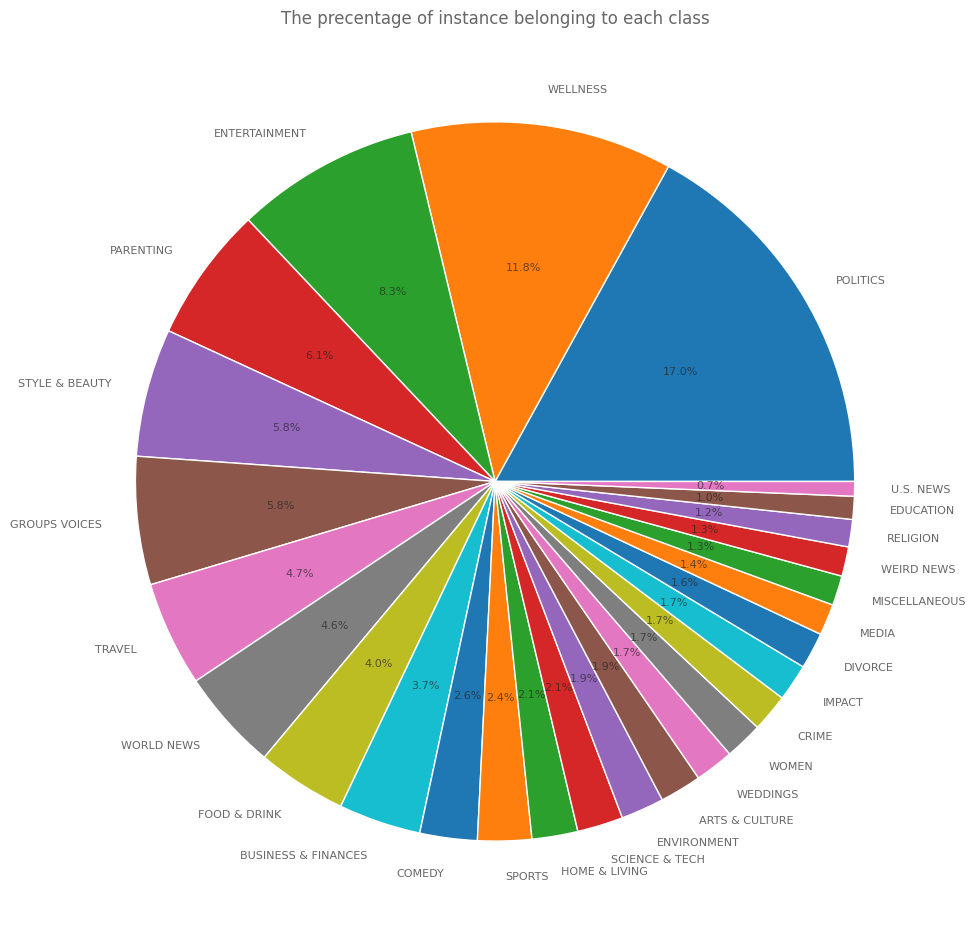

In [11]:
plt.figure(figsize=(10, 10))
plt.pie(x=df.category.value_counts(), labels=df.category.value_counts().index, autopct='%1.1f%%', textprops={'fontsize' : 8,
                                                                                                                'alpha' : .7});
plt.title('The precentage of instance belonging to each class', alpha=.7);
plt.tight_layout();

## Data Transformation

In [12]:
with open('/kaggle/input/english-stopwords/EN-Stopwords.txt', 'r') as f:
    stopwords = f.readlines()
    f.close()
stopwords = [re.sub('\n', '', w) for w in stopwords]

In [13]:
def text_preprocessing(df:pd.DataFrame):
    """
    performing tasks such as tokenization, stop words, numbers, punctuations, and empty strings removal, stemming,
    and lemmatization
    """
    lem = WordNetLemmatizer()
    new_df = pd.DataFrame(columns=['head_desc', 'category'])
    max_len = 0
    for index, row in df.iterrows():
        head_desc = row.headline + " " + row.short_description
        head_desc_tokenized = word_tokenize(head_desc) # Word Tokenization
        punctuation_stopwords_removed = [re.sub('[^\w\s]', '', token) for token in head_desc_tokenized if not token in stopwords] # punctuations and stopwords removal
        number_removed = [re.sub('\d+', '', token) for token in punctuation_stopwords_removed] # numbers removal
        #  head_desc_lemmatized = [lem.lemmatize(token) for token in number_removed] # Word Lemmatization
        empty_str_removed = [token for token in number_removed if token != ''] # head_desc_lemmatized if token != ''] # empty strings removal
        if len(empty_str_removed) > max_len:
            max_len = len(empty_str_removed)
        new_df.loc[index] = {
            'head_desc' : " ".join(empty_str_removed),
            'category' : row['category']
        }
    X, y = new_df['head_desc'], new_df['category']
    return X, y, max_len

In [14]:
X, y, max_len = text_preprocessing(df)

In [15]:
def save_data(name, data):
    with open(name, 'wb') as f:
        pickle.dump(data, f)
        f.close()

In [16]:
save_data('X.h5', X)
save_data('y.h5', y)
save_data('max_len', max_len)

In [17]:
def load_data(name):
    return pickle.load(open(name, 'rb'))

In [18]:
# X = load_data('X.h5')
# y = load_data('y.h5')
# max_len = load_data('max_len')

In [19]:
max_len

133

In [20]:
X.shape, y.shape

((209527,), (209527,))

In [21]:
X

0         Over Million Americans Roll Up Sleeves For Omi...
1         American Airlines Flyer Charged Banned For Lif...
2         Of The Funniest Tweets About Cats And Dogs Thi...
3         The Funniest Tweets From Parents This Week Sep...
4         Woman Who Called Cops On Black BirdWatcher Los...
                                ...                        
209522    RIM CEO Thorsten Heins Significant Plans For B...
209523    Maria Sharapova Stunned By Victoria Azarenka I...
209524    Giants Over Patriots Jets Over Colts Among Mos...
209525    Aldon Smith Arrested ers Linebacker Busted For...
209526    Dwight Howard Rips Teammates After Magic Loss ...
Name: head_desc, Length: 209527, dtype: object

In [22]:
y.head()

0    U.S. NEWS
1    U.S. NEWS
2       COMEDY
3    PARENTING
4    U.S. NEWS
Name: category, dtype: object

In [23]:
y = pd.get_dummies(y) # OHE
classes_name = y.columns.tolist()
y.head()

,ARTS & CULTURE,BUSINESS & FINANCES,COMEDY,CRIME,DIVORCE,EDUCATION,ENTERTAINMENT,ENVIRONMENT,FOOD & DRINK,GROUPS VOICES,...,SCIENCE & TECH,SPORTS,STYLE & BEAUTY,TRAVEL,U.S. NEWS,WEDDINGS,WEIRD NEWS,WELLNESS,WOMEN,WORLD NEWS
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [24]:
y = y.replace([True, False], [1, 0]).values
y.shape

(209527, 27)

## Data Splitting

In [25]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=.3, random_state=42)
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=.5, random_state=42)

## Data Transformation

In [26]:
# create a DistilBertTokenizer object
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert-base-uncased") 

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 3.50kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 4.18MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 6.37MB/s]
config.json: 100%|██████████| 483/483 [00:00<00:00, 268kB/s]


In [27]:
save_data('tokenizer.h5', tokenizer)

In [28]:
# tokenizer = load_data('tokenizer.h5')

In [29]:
def tokenizer_preprocessing(texts, tokenizer):
    """
    In text classification tasks, It is common to have varying lengths of input texts.
    To handle this variability, we should apply the helper method batch_encode_plus on
    a DistilBertTokenizer object to ensure that all the input texts have the same lenght.
    """
    encoded_dict = tokenizer.batch_encode_plus(
        texts,
        return_token_type_ids=False,
        pad_to_max_length=True, # the length of all texts will be equal to a text which has the maximum tokens
        max_length=max_len
    )
    return np.array(encoded_dict['input_ids']) # convert a list to an array

In [30]:
padded_train = tokenizer_preprocessing(X_train, tokenizer)
padded_eval = tokenizer_preprocessing(X_eval, tokenizer)
padded_test = tokenizer_preprocessing(X_test, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [31]:
save_data('padded_train.h5', padded_train)
save_data('padded_eval.h5', padded_eval)
save_data('padded_test.h5', padded_test)

In [32]:
# padded_train = load_data('padded_train.h5')
# padded_eval = load_data('padded_eval.h5')
# padded_test = load_data('padded_test.h5')

In [33]:
padded_train.shape, padded_eval.shape, padded_test.shape

((146668, 133), (31429, 133), (31430, 133))

## Transfer Learning

In [34]:
with dist_strategy.scope():
    pretrained_model = TFAutoModel.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased')
    
    # Transfer Learning -> using transfer learning, we can use a pre-trained model in a customized way.
    input_layer = Input(shape=(max_len,), dtype=tf.int32)
    # we utilize a pre-trained transformer model to process input sequences or texts
    transformer_layers = pretrained_model(input_layer)[0] 
    # The CLS variable stores the representation of the [CLS] token, which is typically used as a aggregate representation of the entire input sequence.
    CLS = transformer_layers[:, 0, :] 
    drop1 = Dropout(.8)(CLS)
    output = Dense(27, activation='softmax')(drop1)
    
    bert_tf = Model(inputs=input_layer, outputs=output)
    bert_tf.compile(
        loss = 'categorical_crossentropy',
        optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01),
        metrics = F1Score(num_classes=27, average='macro')
    )

bert_tf.summary()

model.safetensors: 100%|██████████| 268M/268M [00:01<00:00, 197MB/s]
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 133)]             0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 133,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dropout_19 (Dropout)        (None, 768)               0         
                                                             

## Training Model

In [35]:
EPOCHS = 50
BATCH_SIZE = 32 * dist_strategy.num_replicas_in_sync # The number of input sequences in each batch
STEPS_PER_EPOCH = X_train.shape[0] // BATCH_SIZE # The numebr of batches
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_f1_score', save_best_only=True) 
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = bert_tf.fit(
    padded_train,
    y_train,
    validation_data=(padded_eval, y_eval),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr, early_stopping, model_checkpoint]
)

Epoch 1/50


2024-02-02 17:16:56.507002: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamWeightDecay/AdamWeightDecay/AssignAddVariableOp.
2024-02-02 17:16:56.854549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamWeightDecay/AdamWeightDecay/AssignAddVariableOp.


572/572 [==============================] - ETA: 0s - loss: 1.7129 - f1_score: 0.4109

2024-02-02 17:18:56.385630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-02-02 17:18:56.569410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


572/572 [==============================] - 153s 181ms/step - loss: 1.7129 - f1_score: 0.4109 - val_loss: 1.0848 - val_f1_score: 0.5725 - lr: 2.0000e-05
Epoch 2/50
572/572 [==============================] - 62s 108ms/step - loss: 1.1550 - f1_score: 0.5717 - val_loss: 1.0005 - val_f1_score: 0.6035 - lr: 2.0000e-05
Epoch 3/50
572/572 [==============================] - 62s 108ms/step - loss: 1.0057 - f1_score: 0.6193 - val_loss: 0.9696 - val_f1_score: 0.6230 - lr: 2.0000e-05
Epoch 4/50
572/572 [==============================] - 61s 107ms/step - loss: 0.8939 - f1_score: 0.6586 - val_loss: 0.9715 - val_f1_score: 0.6312 - lr: 2.0000e-05
Epoch 5/50
572/572 [==============================] - 61s 107ms/step - loss: 0.7922 - f1_score: 0.6918 - val_loss: 0.9898 - val_f1_score: 0.6336 - lr: 2.0000e-05
Epoch 6/50
572/572 [==============================] - 61s 107ms/step - loss: 0.6692 - f1_score: 0.7360 - val_loss: 0.9942 - val_f1_score: 0.6336 - lr: 4.0000e-06
Epoch 7/50
572/572 [==================

## Comparing model metrics using the history attribute

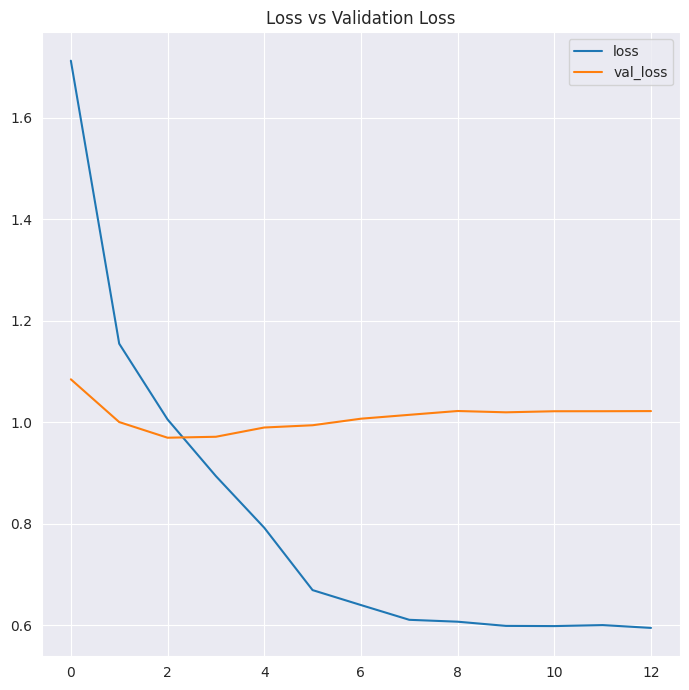

In [36]:
plt.figure(figsize=(7, 7))
plt.plot(history.history['loss'], label='loss');
plt.plot(history.history['val_loss'], label='val_loss');
plt.legend();
plt.title('Loss vs Validation Loss');
plt.tight_layout();

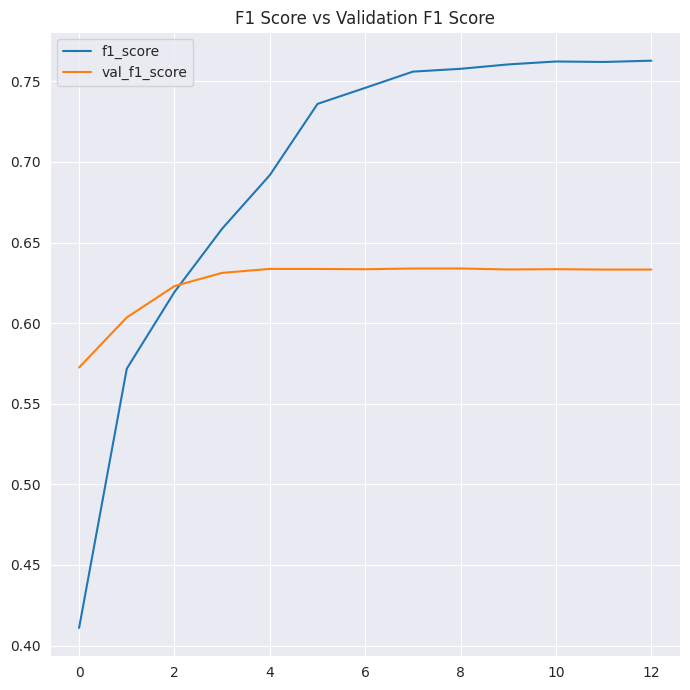

In [37]:
plt.figure(figsize=(7, 7))
plt.plot(history.history['f1_score'], label='f1_score');
plt.plot(history.history['val_f1_score'], label='val_f1_score');
plt.legend();
plt.title('F1 Score vs Validation F1 Score');
plt.tight_layout();

## Inference and Evaluating Model

In [38]:
y_pred = bert_tf.predict(padded_test)
y_pred_class = np.argmax(y_pred, axis=1) # convert the One-Hot-Encoded vecotrs to a single vector
y_pred_class

2024-02-02 17:31:43.157287: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-02-02 17:31:43.299200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


983/983 [==============================] - 20s 14ms/step


array([ 4,  8, 14, ..., 24, 11,  9])

In [39]:
y_test_class = np.argmax(y_test, axis=1)
y_test_class

array([ 4,  8, 14, ...,  5, 24,  9])

In [40]:
print(classification_report(y_true=y_test_class, y_pred=y_pred_class))

              precision    recall  f1-score   support

           0       0.63      0.58      0.60       556
           1       0.62      0.59      0.61      1150
           2       0.55      0.45      0.50       836
           3       0.65      0.63      0.64       552
           4       0.80      0.75      0.77       519
           5       0.58      0.47      0.52       315
           6       0.69      0.79      0.73      2577
           7       0.58      0.62      0.60       608
           8       0.80      0.87      0.83      1253
           9       0.65      0.63      0.64      1806
          10       0.81      0.76      0.79       636
          11       0.53      0.32      0.40       531
          12       0.65      0.53      0.59       466
          13       0.56      0.11      0.18       425
          14       0.68      0.83      0.75      1926
          15       0.83      0.79      0.81      5350
          16       0.62      0.61      0.61       370
          17       0.58    

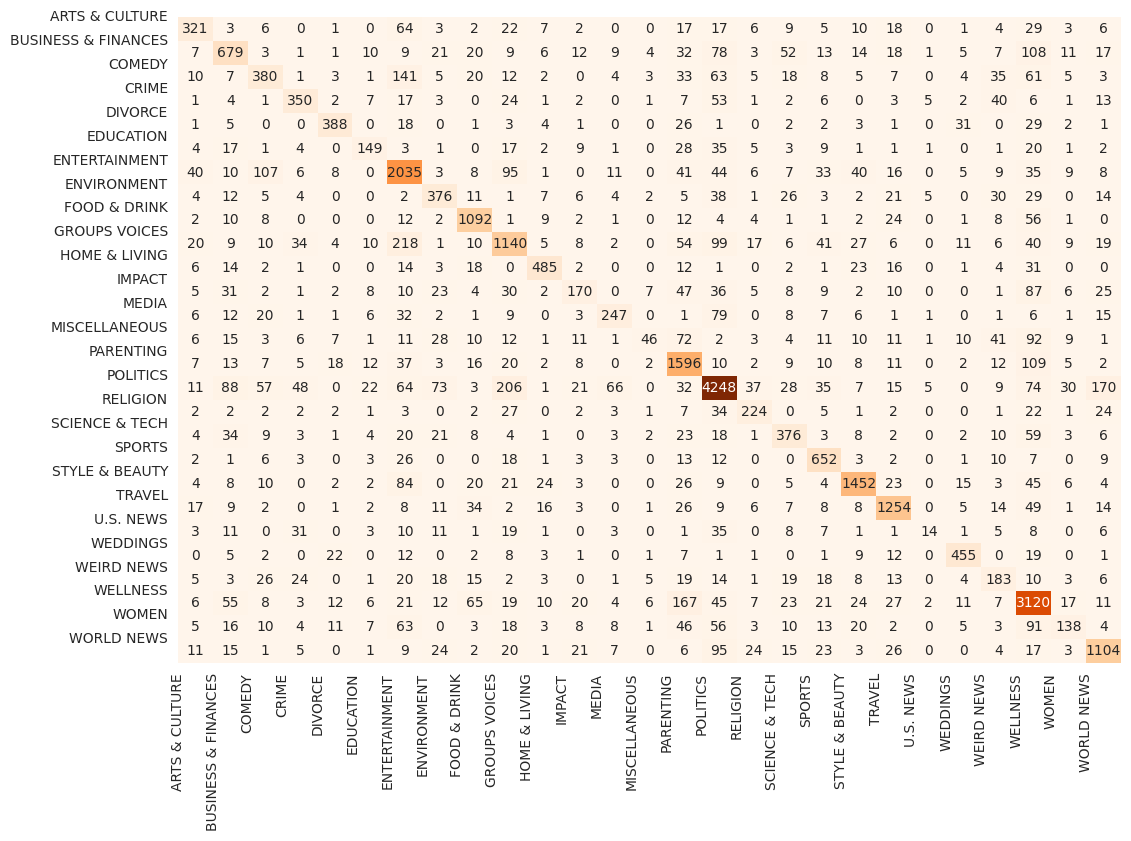

In [41]:
conf_matrix = confusion_matrix(y_true=y_test_class, y_pred=y_pred_class)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', cbar=False);
plt.tight_layout();
plt.xticks(range(27), classes_name, rotation=90);
plt.yticks(range(27), classes_name, rotation=360);